This notebook will train a deep learning natural language algorithm to try to predict the country of origin of a wine base on its description.

First we import the required libraries.

In [2]:
import numpy as np
import pandas as pd #dataframes / data manipulation

#model
from sklearn.model_selection import train_test_split

#natural language toolkit
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

#keras
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
import tensorflow as tf

import matplotlib.pyplot as plt

#suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

2022-10-03 11:14:53.064411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we need to import the datasets.

In [3]:
#we will select only the two columns that will be used: description and country
columns = ['description', 'country']
df_1 = pd.read_csv('./datasets/winemag-data_first150k.csv', usecols=columns)
df_2 = pd.read_csv('./datasets/winemag-data-130k-v2.csv', usecols=columns)

print(df_1.shape)
print(df_2.shape)

(150930, 2)
(129971, 2)


Now we clean and shape the dataframes

In [4]:
#looking for null entries to be removed
print(df_1.info())
print('--------------------------------------')
print(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   country      150925 non-null  object
 1   description  150930 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   country      129908 non-null  object
 1   description  129971 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None


In [5]:
#there seem to be some null values for countries in both datasets
#we can see that by comparing the total entries with the non-null number
#we'll drop them off
df_1.dropna(axis=0, inplace=True)
df_2.dropna(axis=0, inplace=True)

#then we'll concatenate both into one dataframe
df = pd.concat([df_1, df_2])
print(df.shape)

(280833, 2)


In [6]:
#let's see what we got so far
df.describe()

,country,description
count,280833,280833
unique,50,169370
top,US,A little bit funky and unsettled when you pop ...
freq,116901,7


In [7]:
#removing special characters
df['description'] = df['description'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

#converting everything o lowercase so there's no distinction between the same word
df['description'] = df['description'].apply(lambda x: x.lower())

#now to remove the stopwords (the ones that don't affect the result)
stop_words = stopwords.words('english')
df['description'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

#lemmatizing (removing conjugation to convert all the words to their base form)
lemmatizer = WordNetLemmatizer()
df['description'] = df['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

#encode the labels
df['country'] = df['country'].factorize()[0]

In [8]:
#now let's see how our dataframe looks
df.head(15)

,country,description
0,0,tremendous varietal wine hail oakville aged th...
1,1,ripe aroma fig blackberry cassis softened swee...
2,0,mac watson honor memory wine made mother treme...
3,0,spent month new french oak incorporates fruit ...
4,2,top wine la b gude named highest point vineyar...
5,1,deep dense pure opening bell toro winner aroma...
6,1,slightly gritty black fruit aroma include swee...
7,1,lush cedary black fruit aroma luxe offer note ...
8,0,named vineyard formerly bottled delancellotti ...
9,0,producer source two block vineyard wine one hi...


Now we prepare the data for training and testing

In [9]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['country'])

#check how many unique words we have
vocab_size = len(set(' '.join(X_train).split()))
print('Vocab size: ', vocab_size)

Vocab size:  31104


In [10]:
#encoding the words with numbers for the model to be able to process them
#each unique word turns into an integer, then converted to a binary vector
train = [one_hot(d, vocab_size) for d in X_train]
test = [one_hot(d, vocab_size) for d in X_test]


In [11]:
#padding every description to the length of 100 words
max_length = 100
padded_train = pad_sequences(train, maxlen=max_length, padding='post')
padded_test = pad_sequences(test, maxlen=max_length, padding='post')

Here comes the model

In [12]:
#embedding size
embedding_size = 32
#number of classes - count the number of countries available
num_classes = df['country'].nunique()
#model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
#bidirectional LSTM
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-10-03 11:15:54.191052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           995328    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
Total params: 1,015,218
Trainable params: 1,015,218
Non-trainable params: 0
_________________________________________________________________


And the training

In [13]:
history = model.fit(padded_train, y_train, epochs=20, verbose=1)

Epoch 1/20
6582/6582 [==============================] - 211s 32ms/step - loss: 0.8431 - accuracy: 0.7378
Epoch 2/20
6582/6582 [==============================] - 228s 35ms/step - loss: 0.5289 - accuracy: 0.8233
Epoch 3/20
6582/6582 [==============================] - 252s 38ms/step - loss: 0.4232 - accuracy: 0.8600
Epoch 4/20
6582/6582 [==============================] - 270s 41ms/step - loss: 0.3579 - accuracy: 0.8828
Epoch 5/20
6582/6582 [==============================] - 359s 55ms/step - loss: 0.3146 - accuracy: 0.8975
Epoch 6/20
6582/6582 [==============================] - 418s 64ms/step - loss: 0.2790 - accuracy: 0.9088
Epoch 7/20
6582/6582 [==============================] - 247s 38ms/step - loss: 0.2514 - accuracy: 0.9181
Epoch 8/20
6582/6582 [==============================] - 258s 39ms/step - loss: 0.2279 - accuracy: 0.9260
Epoch 9/20
6582/6582 [==============================] - 269s 41ms/step - loss: 0.2080 - accuracy: 0.9327
Epoch 10/20
6582/6582 [==============================] 

In [15]:
loss, accuracy = model.evaluate(padded_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

2195/2195 [==============================] - 13s 6ms/step - loss: 0.5010 - accuracy: 0.9045
Accuracy: 90.448517


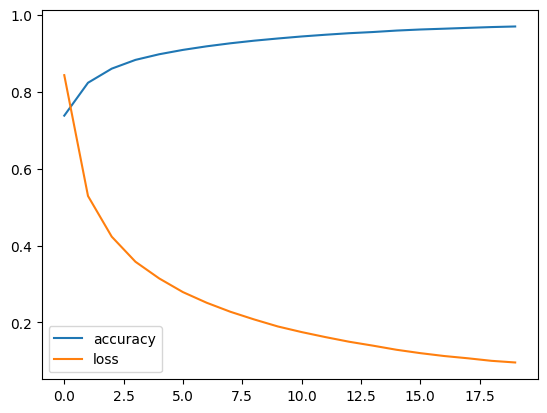

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])
plt.show()